<a href="https://colab.research.google.com/github/samarthkadaba/COVID-19-Cases-Predictor/blob/master/COVID_19_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Dropout
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.python.keras.activations import relu, sigmoid, linear, exponential, softmax, tanh

In [0]:
def updateData():  


  site = "https://www.worldometers.info/coronavirus/country/us/"
  hdr = {'User-Agent': 'Mozilla/5.0'}
  req = Request(site,headers=hdr)
  ##pd.set_option('display.max_rows', None)
  ##pd.set_option('display.max_columns', None)
  page = urlopen(req)
  soup = BeautifulSoup(page)
  table = soup.find('table')
  table_rows = table.find_all('tr')
  col_labels = soup.find_all('th')
  all_headers = []
  col_str = str(col_labels)
  cleantext2 = BeautifulSoup(col_str, "lxml").get_text()
  all_headers.append(cleantext2)
  df2 = pd.DataFrame(all_headers)
  df3 = df2[0].str.split(',', expand=True)
  data = []
  for tr in table_rows:
      td = tr.find_all('td')
      row = [i.text for i in td]
      data.append(row)
  
  
  df = pd.DataFrame(data)
  frames = [df3, df]
  df4 = pd.concat(frames)
  df4[0] = df4[0].str.strip('[')
  df4.drop(df4.index[[0,2]], inplace = True)
  df4.drop(df4.columns[[2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]], axis=1, inplace=True)
  df4[0] = df4[0].str.replace(r'\n', '')
  df4[1] = (df4[1].str.replace(r',', '')).astype(float)
  df4[3] = df4[3].str.replace(r'\n', '')
  df4[3][51, 57, 58] = 0.00
  df4[3] = (df4[3].str.replace(r',', '')).astype(float)
  df4 = df4.fillna(0)


  df5 = df4.iloc[0:57, :]
  df5 = df5.reindex([5, 12, 8, 2, 9, 10, 17, 13, 20, 4, 3, 21, 11, 23, 7, 18, 16, 22, 19, 24, 15, 35, 25, 26, 6, 34, 32, 30, 14, 29, 37, 27, 38, 55, 28, 39, 42, 46, 31, 47, 45, 41, 44, 48, 36, 40, 49, 50, 52, 33, 43, 51, 53, 56, 57, 58])
  df5.drop(df5.index[[52, 53, 54, 55]], inplace = True)



 
    
  return df5


In [0]:

def loadData(df5):
  data = pd.read_csv('/content/COVID-19_Data_04042020.csv')
  data = pd.DataFrame(data, columns = ['example', 'state', 'pop', 'density', 'days', 'cases', 'deaths'])
  num_examples = data['example'].count()
  data = data.head(num_examples)
  numexamples = data.shape[0]
  dc = data.iloc[numexamples-52:numexamples, :]
  dc.loc[:, 'days'] = dc.loc[:, 'days']+1
  dc.loc[:, 'cases'] =  df5.iloc[:, 1].values
  dc.loc[:, 'deaths'] = df5.iloc[:, 2].values
  frames = [data, dc]
  data = pd.concat(frames)
  data.to_csv(r'/content/COVID-19_Data_04052020.csv', index = False)
  x = (data[['pop', 'density', 'days']])
  x = x.to_numpy()
  x = x.astype(float)
  y = (data[['cases']])
  y = y.to_numpy()
  y = y.astype(float)
  y = np.reshape(y, (-1,1))

  return x,y


In [0]:
def plotData(x, y, xlabel, ylabel):

  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.scatter([x], [y], marker = 'o')

In [467]:
web_data = updateData()
x, y = loadData(web_data)

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
print(scaler_x.fit(x))
xscale=scaler_x.transform(x)
print(scaler_y.fit(y))
yscale=scaler_y.transform(y)

X_train, X_test, y_train, y_test = train_test_split(xscale, yscale)

MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  se

In [477]:
def create_model(layers, activation):
  model = Sequential()
  for i, nodes in enumerate(layers):
   
    if(i == 0):
      model.add(Dense(nodes, input_dim = 3, kernel_initializer = 'normal', activation=activation))
      model.add(Dropout(0.5))
    else:
      model.add(Dense(nodes, activation = activation))
      

  model.add(Dense(1, activation = 'linear'))

  model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse', 'mae'])

  return model

model_checked = KerasRegressor(build_fn = create_model, verbose = 0)
model_checked

In [478]:
layers = [(64,32),  (64,32,16), (64)]
activations = ['sigmoid','exponential']
param_grid = dict(layers = layers, activation=activations, batch_size = [52,104,208], epochs = [500,1000,1500])
grid = GridSearchCV(estimator = model_checked, param_grid = param_grid, cv=KFold(n_splits = 3, shuffle=True))
grid_result = grid.fit(X_train, y_train)
print([grid_result.best_score_, grid_result.best_params_])

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: 'int' object is not iterable

  FitFailedWarning)


[-0.015455960761755705, {'activation': 'sigmoid', 'batch_size': 104, 'epochs': 1000, 'layers': (64, 32, 16)}]


In [0]:
model = Sequential()
model.add(Dense(64, input_dim = 3, kernel_initializer = 'normal', activation = 'exponential'))
model.add(Dense(32, activation = 'exponential'))
model.add(Dense(16, activation = 'exponential'))
model.add(Dense(1, activation = 'linear'))
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse', 'mae'])

In [480]:

model = grid_result.best_estimator_
history = model.fit(X_train, y_train, verbose = 1, validation_split = 0.2)


Epoch 1/1000
2/2 [==============================] - 0s 64ms/step - loss: 0.0154 - mse: 0.0156 - mae: 0.0593 - val_loss: 0.0236 - val_mse: 0.0236 - val_mae: 0.0699
Epoch 2/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0144 - mse: 0.0149 - mae: 0.0582 - val_loss: 0.0239 - val_mse: 0.0239 - val_mae: 0.0582
Epoch 3/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0145 - mse: 0.0147 - mae: 0.0492 - val_loss: 0.0239 - val_mse: 0.0239 - val_mae: 0.0587
Epoch 4/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0146 - mse: 0.0154 - mae: 0.0553 - val_loss: 0.0236 - val_mse: 0.0236 - val_mae: 0.0683
Epoch 5/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0150 - mse: 0.0143 - mae: 0.0541 - val_loss: 0.0236 - val_mse: 0.0236 - val_mae: 0.0697
Epoch 6/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0150 - mse: 0.0142 - mae: 0.0556 - val_loss: 0.0236 - val_mse: 0.0236 - val_mae: 0.0681
Epoch 7/1000
2/2 [====

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


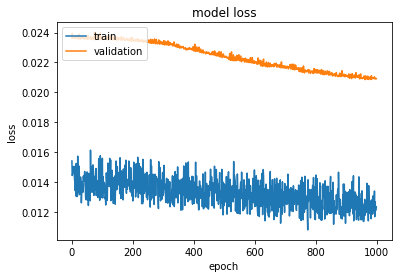

In [481]:
print(history.history.keys())
#Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


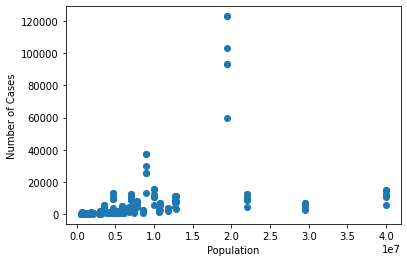

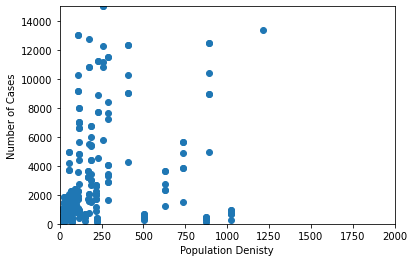

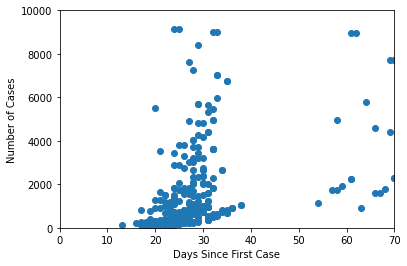

In [482]:
x, y = loadData(web_data)
plotData(x[:, 0], y, 'Population', 'Number of Cases')
plt.figure()
plt.axis([0, 2000, 0, 15000])
plotData(x[:, 1], y, 'Population Denisty', 'Number of Cases')
plt.figure()
plt.axis([0, 70, 0, 10000])
plotData(x[:, 2], y, 'Days Since First Case', 'Number of Cases')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


1 [19445.695]
2 [14407.276]
3 [11834.698]
4 [10781.316]
5 [7370.484]
6 [10998.048]
7 [6581.474]
8 [6767.427]
9 [6619.2627]
10 [5657.4136]
11 [5942.7764]
12 [5290.9224]
13 [9194.207]
14 [8476.33]
15 [8006.283]
16 [4657.8403]
17 [4489.594]
18 [4093.1223]
19 [4367.7646]
20 [6976.768]
21 [4132.8354]
22 [3966.259]
23 [3652.839]
24 [2883.7422]
25 [3166.1992]
26 [3401.866]
27 [3997.5454]
28 [3129.617]
29 [2886.165]
30 [2804.848]
31 [2556.9668]
32 [2835.785]
33 [2185.553]
34 [2155.9448]
35 [2162.999]
36 [2525.3298]
37 [1728.3265]
38 [2168.6602]
39 [1398.1934]
40 [981.2827]
41 [1954.2275]
42 [2324.9492]
43 [1276.7618]
44 [1247.7451]
45 [2463.1277]
46 [1305.7036]
47 [1263.084]
48 [1095.0409]
49 [978.7913]
50 [3995.4465]
51 [1347.6014]
52 [1002.12225]
53 [19561.234]
54 [14614.401]
55 [12075.194]
56 [11034.08]
57 [7655.847]
58 [11237.0205]
59 [6872.7197]
60 [7055.85]
61 [6908.829]
62 [5953.896]
63 [6235.8203]
64 [5588.354]
65 [9451.38]
66 [8742.025]
67 [8276.837]
68 [4957.291]
69 [4789.7915]
70 [4

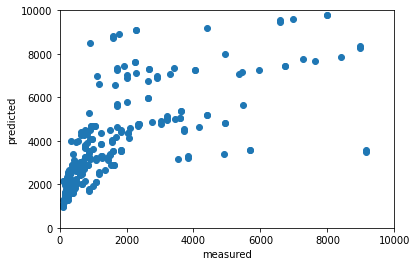

In [483]:


x, y = loadData(web_data)
x = np.expand_dims(x, axis = 1)
predictions = []
for i in range(len(x)):
  x[i]= scaler_x.transform(x[i].reshape(1,-1))
  ynew= model.predict(x[i])
  #invert normalize
  ynew = scaler_y.inverse_transform(ynew.reshape(1,-1))
  x[i] = scaler_x.inverse_transform(x[i])
  predictions.append(ynew[0])
##print("X=%s, Predicted=%s" % (Xnew[0], ynew[0]))
plt.figure()
plt.axis([0, 10000, 0, 10000])
plotData(y, predictions, 'measured', 'predicted' )
for i in range(len(predictions)):
  print(i+1, predictions[i])


In [484]:
pop = float(input("Enter the popualtion: "))
dense = float(input("Enter the population density: "))
days = float(input("Enter the days since first case: "))
x_spec = [[pop, dense, days]]
x_spec = scaler_x.transform(x_spec)
y_hat = model.predict(x_spec)
y_hat = scaler_y.inverse_transform(y_hat.reshape(-1,1))
x_spec = scaler_x.inverse_transform(x_spec)
print("X: %s, Predicte = %s" % (x_spec[0], y_hat[0]))

Enter the popualtion: 854223
Enter the population density: 460
Enter the days since first case: 44
X: [8.54223e+05 4.60000e+02 4.40000e+01], Predicte = [3752.539]
